In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("../../")
#from utils.dataset_generator import load_data, filter_samples
from tqdm import tqdm

In [2]:
"""
world_bounds = np.array([[
    [3.8, 2.8], 
    [7.2, 5.2]
]])
"""
world_bounds = np.array([[
    [1, 1], 
    [10, 10]
]])

"""
[1, 1], 
[10, 10]
"""

obstacle_bounds = np.array([
    # Obstacle 1
    [[ 8.91985225,  3.84545202],
     [10.66074355,  4.99807121]],
    # Obstacle 2
    [[3.63246185, 1.09008461],
     [4.11128521, 3.03555758]],
    # Obstacle 3
    [[9.43293506, 2.21096876],
     [9.92049135, 4.53472772]],
    # Obsatcle 4
    [[6.94135996, 6.35929963],
     [7.20650368, 7.51843864]],
    # Obstacle 5
    [[1.78852858, 8.83265186],
     [3.30866274, 8.83481765]],
    # Obstacle 6
    [[5.94550616, 6.42045643],
     [8.13677819, 6.57786723]],
    # Obstacle 7
    [[4.46677218, 5.2867644 ],
     [5.4343571 , 6.29994598]],
    # Obstacle 8
    [[7.56080683, 4.1982659 ],
     [9.89202105, 5.45710442]],
    # Obstacle 9
    [[ 2.31954943,  9.68308763],
     [ 2.44298565, 10.1775785 ]],
    # Obstacle 10
    [[0.86895121, 4.83750394],
     [2.69494379, 5.59028893]]
])

In [3]:
world_bounds.shape

(1, 2, 2)

In [4]:
obstacle_bounds.shape

(10, 2, 2)

In [5]:
def get_line_segments_from_rectangles(rectangles: np.ndarray) -> np.ndarray:
    line_segment_list = []
    rect_segment_list = []
    for rectangle in rectangles:
        line_1 = np.empty((1,2,2))
        line_2 = np.empty((1,2,2))
        line_3 = np.empty((1,2,2))
        line_4 = np.empty((1,2,2))

        line_1[:,0,0] = rectangle[0,0]
        line_1[:,0,1] = rectangle[0,1]
        line_1[:,1,0] = rectangle[1,0]
        line_1[:,1,1] = rectangle[0,1]

        line_2[:,0,0] = rectangle[1,0]
        line_2[:,0,1] = rectangle[0,1]
        line_2[:,1,0] = rectangle[1,0]
        line_2[:,1,1] = rectangle[1,1]
        
        line_3[:,0,0] = rectangle[1,0]
        line_3[:,0,1] = rectangle[1,1]
        line_3[:,1,0] = rectangle[0,0]
        line_3[:,1,1] = rectangle[1,1]

        line_4[:,0,0] = rectangle[0,0]
        line_4[:,0,1] = rectangle[1,1]
        line_4[:,1,0] = rectangle[0,0]
        line_4[:,1,1] = rectangle[0,1]

        line_segment_list.append(line_1)
        line_segment_list.append(line_2)
        line_segment_list.append(line_3)
        line_segment_list.append(line_4)

        rect = np.array([line_1[0,0], line_2[0,0], line_3[0,0], line_4[0,0]])
        rect_segment_list.append(rect)
    del rect_segment_list[0]
    
    return np.concatenate(line_segment_list, axis=0), rect_segment_list

In [6]:
total_obstacles = np.concatenate([world_bounds, obstacle_bounds], axis=0)
line_segments, rects = get_line_segments_from_rectangles(total_obstacles)

In [7]:
line_segments.shape

(44, 2, 2)

In [8]:
def check_collision(rays, line_segments, pos):
    x1 = line_segments[:,0,0]
    y1 = line_segments[:,0,1]
    x2 = line_segments[:,1,0]
    y2 = line_segments[:,1,1]

    x3 = rays[:,0,0]
    y3 = rays[:,0,1]
    x4 = rays[:,1,0]
    y4 = rays[:,1,1]

    a = np.subtract.outer(x1,x3)    # (2, 20)
    b = np.subtract.outer(y1,y3)    # (2, 20)

    numerator_t = a*(y3-y4) - b*(x3-x4)
    numerator_u = a*(y1-y2)[:,None] - b*(x1-x2)[:,None]

    denominator = np.multiply.outer((x1-x2), (y3-y4)) - np.multiply.outer((y1-y2), (x3-x4))

    if np.any(denominator, where=0):
        print("denominator is zero!")
        return None

    t = numerator_t / denominator   # rays
    u = numerator_u / denominator   # obstacles

    conditions = (0<=t) * (t<=1) * (0<=u)# * (u<=1)  # boolean table of intersections between all objects and all rays
    #conditions = (0<=u) * (u<=1)  # boolean table of intersections between all objects and all hypothetical rays (direction of rays)
    condition = np.logical_or.reduce(conditions)    # boolean vector of rays having any intersection point with an obstacle

    if condition.all() == True:
        x_intersect_list = []
        y_intersect_list = []
        for i in range(rays.shape[0]):
            #x_intersect_list.append(x1[i] + t[i][conditions[i]]*(x2[i]-x1[i]))
            #y_intersect_list.append(y1[i] + t[i][conditions[i]]*(y2[i]-y1[i]))
            #x_intersect_list.append(x3[i] + u[:,i][conditions[:,i]]*(x4[i]-x3[i]))
            #y_intersect_list.append(y3[i] + u[:,i][conditions[:,i]]*(y4[i]-y3[i]))

            ray_intersects_x = x3[i] + u[:,i][conditions[:,i]]*(x4[i]-x3[i])
            ray_intersects_y = y3[i] + u[:,i][conditions[:,i]]*(y4[i]-y3[i])

            distance = np.sqrt((ray_intersects_x-pos[0])**2 + (ray_intersects_y-pos[1])**2)
            closest_intersect_idx = np.argmin(distance)

            x_intersect_list.append(ray_intersects_x[closest_intersect_idx])
            y_intersect_list.append(ray_intersects_y[closest_intersect_idx])

        x_intersect = np.array(x_intersect_list)
        y_intersect = np.array(y_intersect_list)

        intersection_points = np.stack([x_intersect, y_intersect], axis=1)
    else:
        return (None, condition)

    return (intersection_points, condition)


In [9]:
def calc_offset(pos: np.ndarray, angles: np.ndarray, magnitudes: np.ndarray) -> np.ndarray:
    offset_x = np.cos(angles)*magnitudes
    offset_y = np.sin(angles)*magnitudes
    offset = pos + np.stack([offset_x, offset_y], axis=1)
    return offset

In [10]:
def get_beam_reading_os(pose: np.ndarray, line_segments: np.ndarray, num_rays: int, fov: int) -> tuple:
    pos = np.array([pose[:2]]).repeat(num_rays, 0)
    angles = np.linspace(-(fov/2)+pose[2],(fov/2)+pose[2], num=num_rays)
    
    magnitudes = np.ones(num_rays)*0.01

    offset_x = np.cos(angles)*magnitudes
    offset_y = np.sin(angles)*magnitudes

    offset = np.stack([offset_x, offset_y], axis=1)

    offset_array = pos + offset

    rays = np.stack([pos, offset_array], axis=1)

    intersection_points, mask = check_collision(
        rays=rays, 
        line_segments=line_segments,
        pos=pos[0]
    )

    if mask.all() == True:
        magnitudes = np.sqrt(((intersection_points-pos)**2).sum(-1))
        offset_array = calc_offset(pos, angles, magnitudes)
        rays = np.stack([pos, offset_array], axis=1)
        pass
    else:
        raise ValueError("not all rays hit a target!")
        
    return (intersection_points, rays, magnitudes)

In [11]:
def get_beam_reading(pose: np.ndarray, line_segments: np.ndarray, num_rays: int, fov: int) -> tuple:
    pos = np.array([pose[:2]]).repeat(num_rays, 0)
    angles = np.linspace(-(fov/2)+pose[2],(fov/2)+pose[2], num=num_rays)
    
    magnitudes = np.ones(num_rays)*0.01

    offset_x = np.cos(angles)*magnitudes
    offset_y = np.sin(angles)*magnitudes

    offset = np.stack([offset_x, offset_y], axis=1)

    offset_array = pos + offset
    cnt = 1
    while True:
        print("cnt: ", cnt)
        cnt +=1
        rays = np.stack([pos, offset_array], axis=1)

        intersection_points, mask = check_collision(
            rays=rays, 
            line_segments=line_segments
        )

        if mask.all() == True:
            magnitudes = np.sqrt(((intersection_points-pos)**2).sum(-1))

            offset_array = calc_offset(pos, angles, magnitudes)
            rays = np.stack([pos, offset_array], axis=1)
            break
        else:
            ray_growth = np.logical_not(mask).astype(int)*0.01  # invert mask convert it from bool to int and calculate ray growth for rays which haven't already hit a target

            magnitudes += ray_growth
            offset_array = calc_offset(pos, angles, magnitudes)
    return (intersection_points, rays, magnitudes)

In [12]:
num_rays = 200
pose = [4.5, 4.5, np.deg2rad(170)]
fov = np.deg2rad(180)

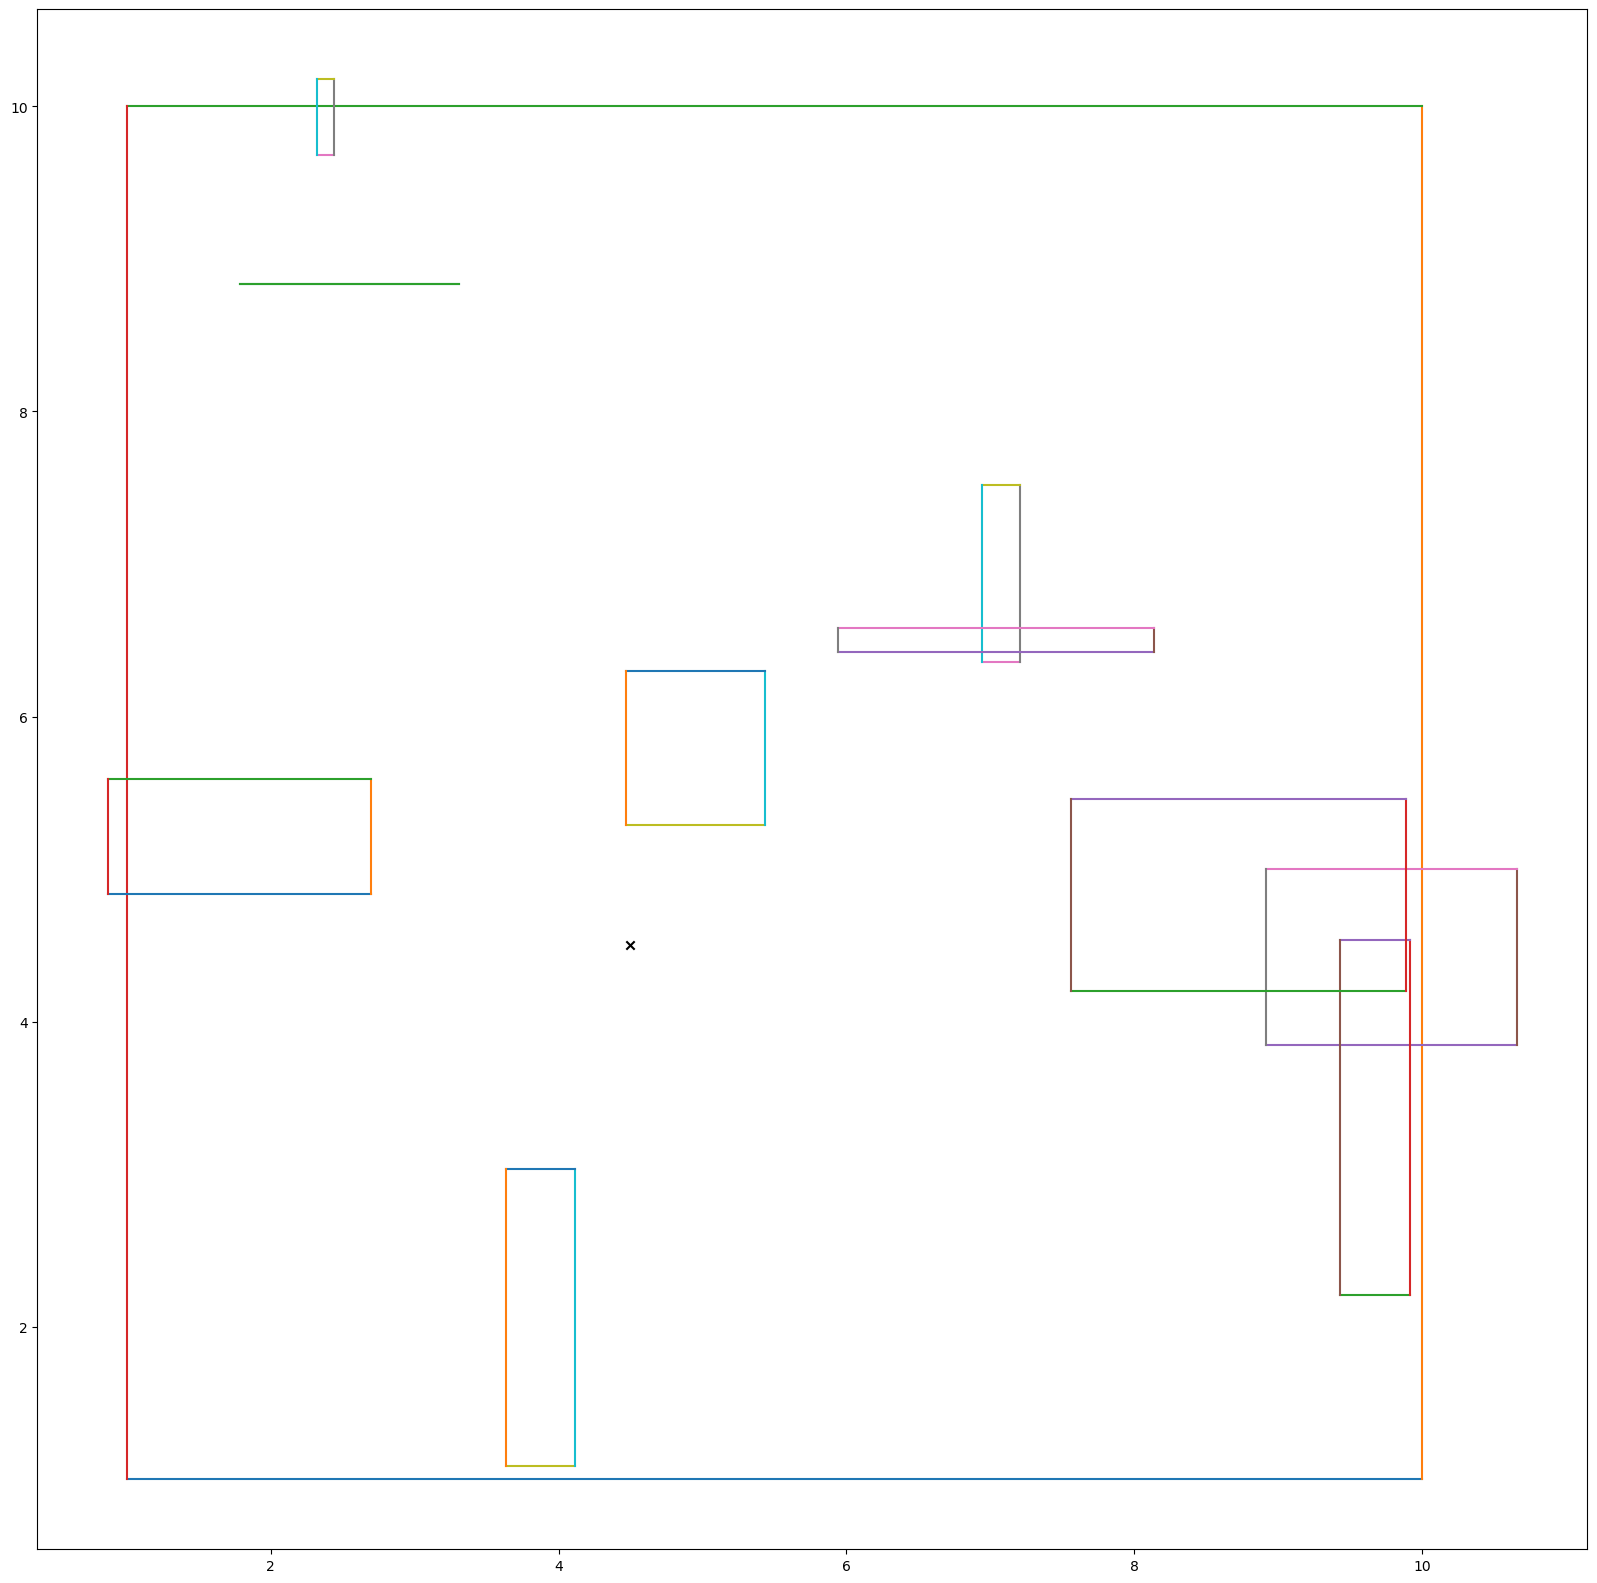

In [13]:
plt.figure(figsize=(20,20))

for line_segment in line_segments:
    plt.plot(line_segment[:,0], line_segment[:,1], label="obstacle")
plt.scatter(pose[0], pose[1], marker="x", color="black")
#plt.legend()
plt.show()

In [14]:
intersection_points, rays, magnitudes = get_beam_reading_os(
    pose=pose,
    line_segments=line_segments,
    num_rays=num_rays,
    fov=fov
)

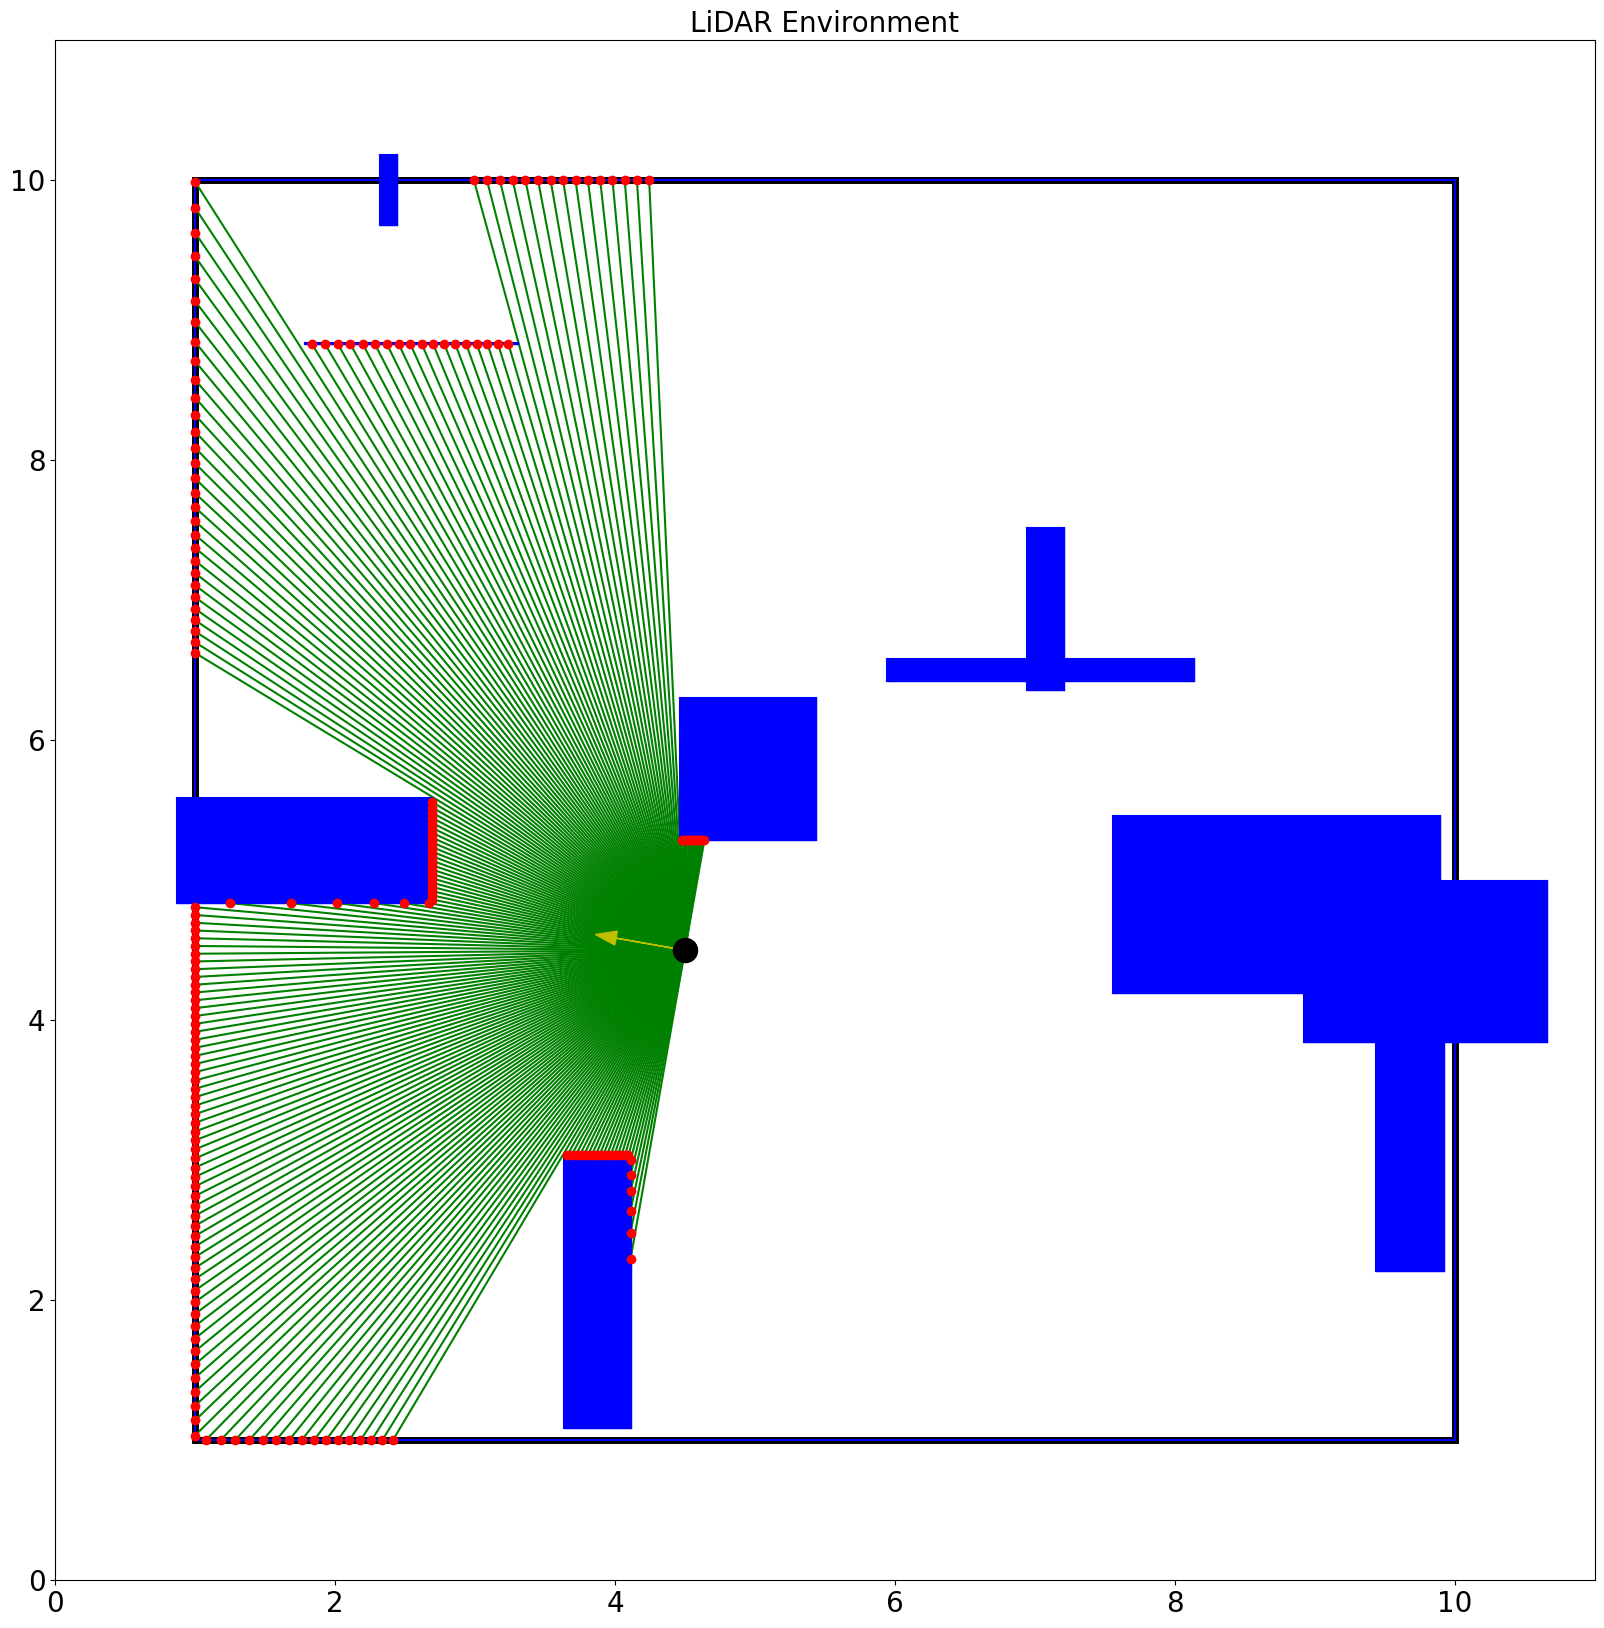

In [19]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def generatePolygonPatchCollection(listOfNumpyPolygons, colorV="blue", alphaV=0.4):
    polygons = []
    for p in listOfNumpyPolygons:
        polygons.append(Polygon(p, closed=True))

    return PatchCollection(polygons, alpha=alphaV, color=colorV)

def ax_plot_world(ax, name="NULL"):
    # ax limits
    world_bounds = np.array([[1, 1], [10, 1], [10, 10], [1, 10]])
    xlim_lower = np.min(world_bounds[:, 0]) - 1
    xlim_upper = np.max(world_bounds[:, 0]) + 1
    ylim_lower = np.min(world_bounds[:, 1]) - 1
    ylim_upper = np.max(world_bounds[:, 1]) + 1

    ax.set_xlim(xlim_lower, xlim_upper)
    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_aspect("equal")

    # plot world bounds
    wb_patch = Polygon(
        world_bounds, facecolor="None", edgecolor="black", linewidth=5, zorder=-1
    )
    ax.add_patch(wb_patch)

    # plot obstacles
    obstacles = rects
    obs_patch = generatePolygonPatchCollection(obstacles, "blue", 1.0)
    ax.add_collection(obs_patch)

    # set title
    #ax.set_title("num_obstacles={0}, seed={1}".format(self.num_obs, self.seed_obs))
    ax.set_title(name, fontsize=20)

fig, ax1 = plt.subplots(1,1,figsize=(20,20))
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])
ax1.tick_params(axis='both', which='major', labelsize=20)

ax_plot_world(ax1, "LiDAR Environment")

for ray in rays:
    ax1.plot(ray[:,0], ray[:,1], label="ray", color="green", zorder=1)
for line_segment in line_segments:
    ax1.plot(line_segment[:,0], line_segment[:,1], label="obstacle", color="blue", zorder=1)
#plt.legend()
ax1.scatter(intersection_points[:,0], intersection_points[:,1], color="red", zorder=2)
ax1.scatter(pose[0], pose[1], marker="o", color="black", zorder=2, s=300)


dx = np.cos(pose[-1])*0.5
dy = np.sin(pose[-1])*0.5

ax1.arrow(pose[0], pose[1], dx, dy, color='y', lw=1, head_width=0.1)
plt.show()

In [20]:
pose_list = [[4.2900, 3.2380, 2.5736],
        [4.1500, 3.4393, 2.4265],
        [4.3739, 3.6336, 2.3847],
        [4.6248, 3.5066, 2.3880],
        [4.5473, 3.3401, 2.3141],
        [4.6930, 3.1559, 2.2302]]

In [21]:
state_dict = {
    "poses": pose_list,
    "intersection_points": [],
    "rays": [],
    "magnitudes": []
}

for pose in pose_list:
    print(pose)
    intersection_points, rays, magnitudes = get_beam_reading_os(
        pose=pose,
        line_segments=line_segments,
        num_rays=num_rays,
        fov=fov
    )

    state_dict["intersection_points"].append(intersection_points)
    state_dict["rays"].append(rays)
    state_dict["magnitudes"].append(magnitudes)

[4.29, 3.238, 2.5736]
[4.15, 3.4393, 2.4265]
[4.3739, 3.6336, 2.3847]
[4.6248, 3.5066, 2.388]
[4.5473, 3.3401, 2.3141]
[4.693, 3.1559, 2.2302]


In [22]:
len(state_dict["intersection_points"])

6

i
i
i
i
i
i


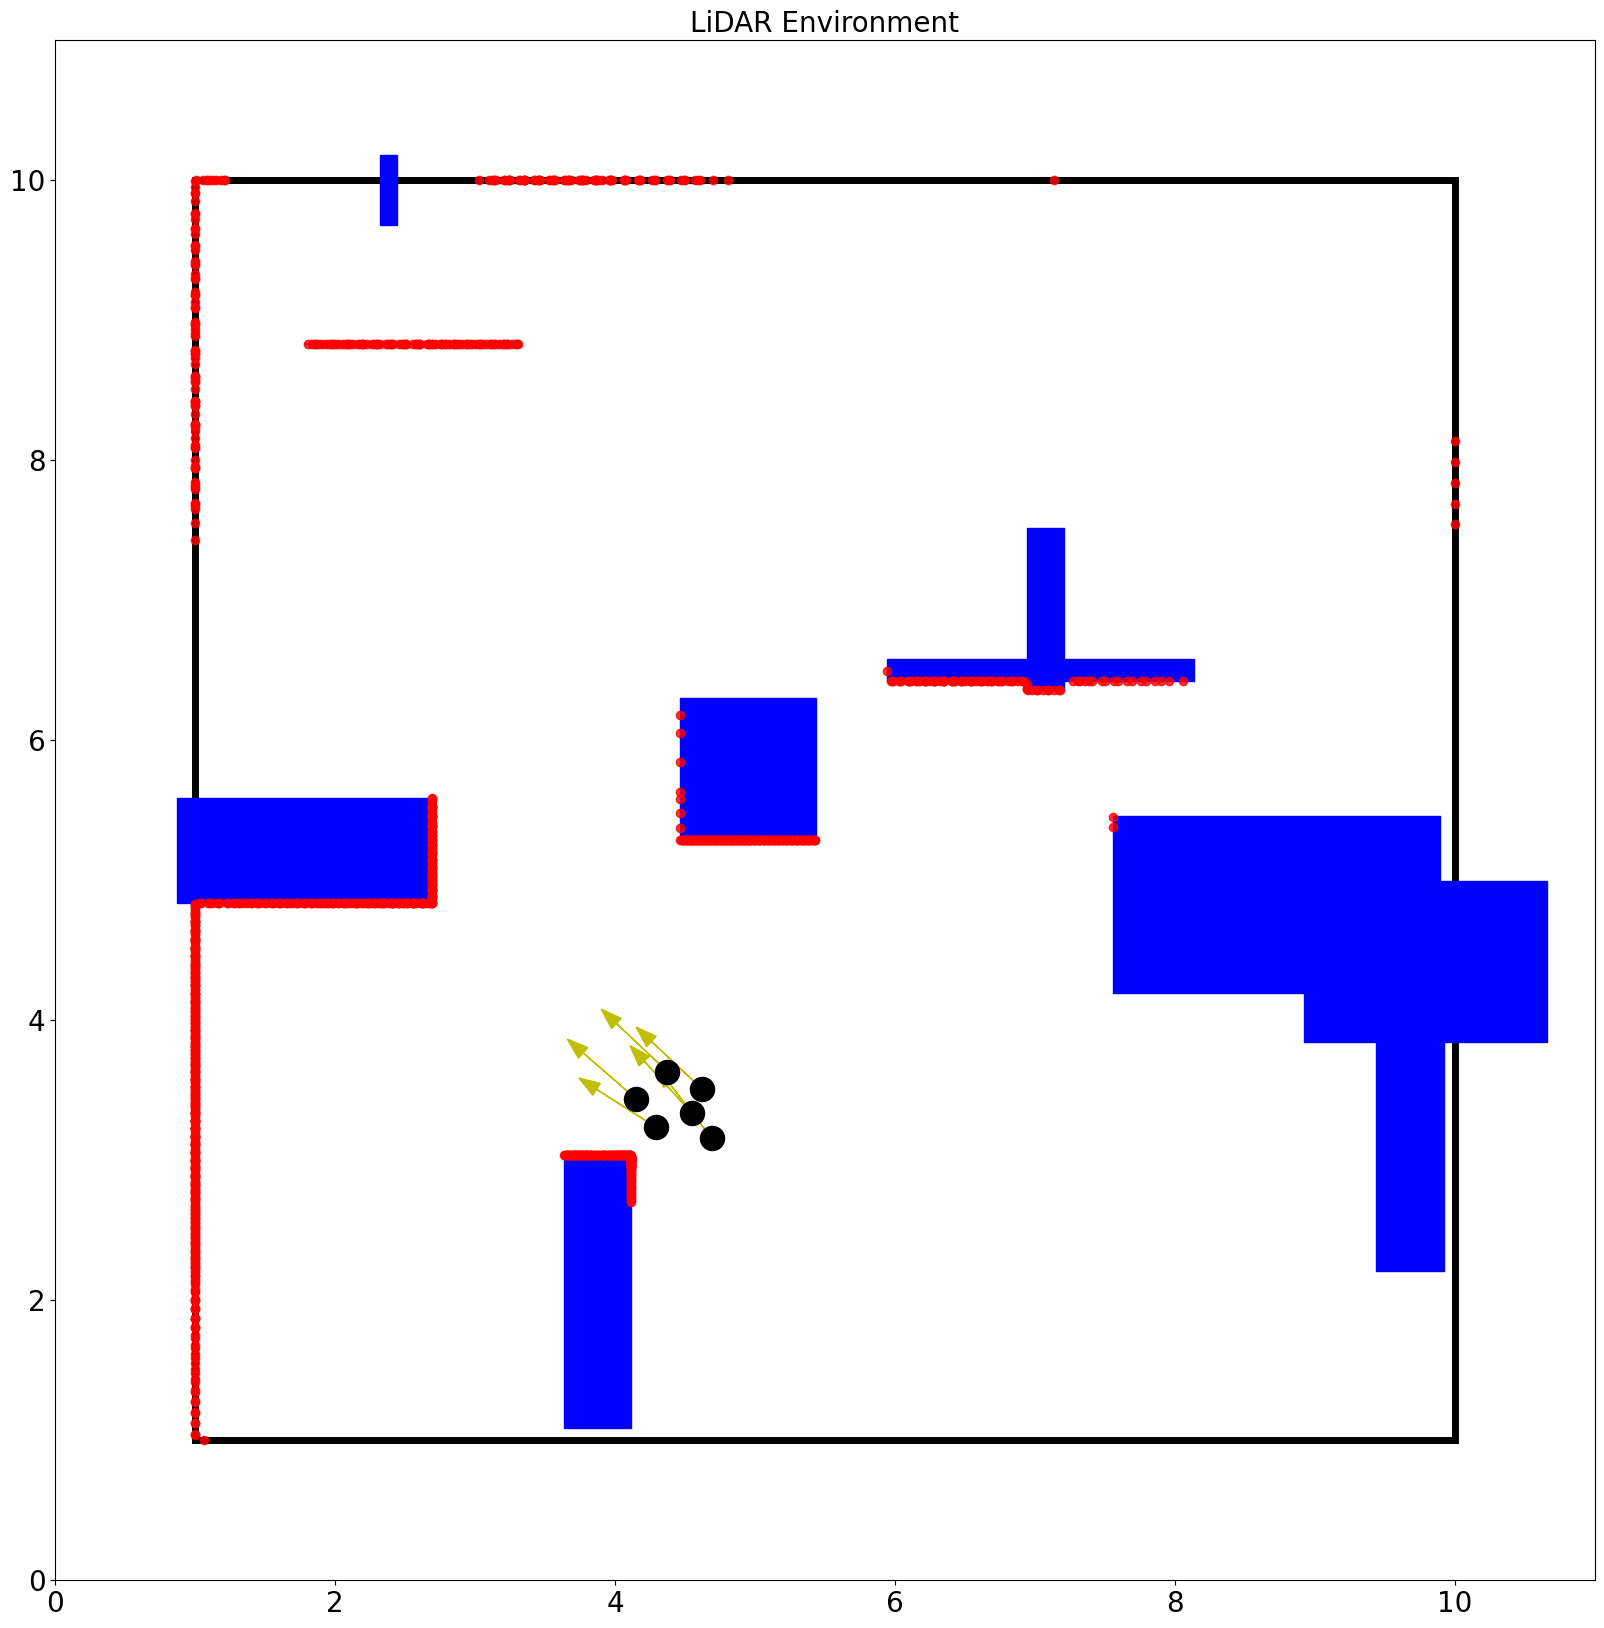

In [24]:
fig, ax1 = plt.subplots(1,1,figsize=(20,20))
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])
ax1.tick_params(axis='both', which='major', labelsize=20)

ax_plot_world(ax1, "LiDAR Environment")

for pose, intersection_points in zip(pose_list, state_dict["intersection_points"]):
    print("i")
    ax1.scatter(intersection_points[:,0], intersection_points[:,1], color="red", zorder=2, alpha=0.8)
    ax1.scatter(pose[0], pose[1], marker="o", color="black", zorder=2, s=300)


    dx = np.cos(pose[-1])*0.5
    dy = np.sin(pose[-1])*0.5

    ax1.arrow(pose[0], pose[1], dx, dy, color='y', lw=1, head_width=0.1)
plt.show()

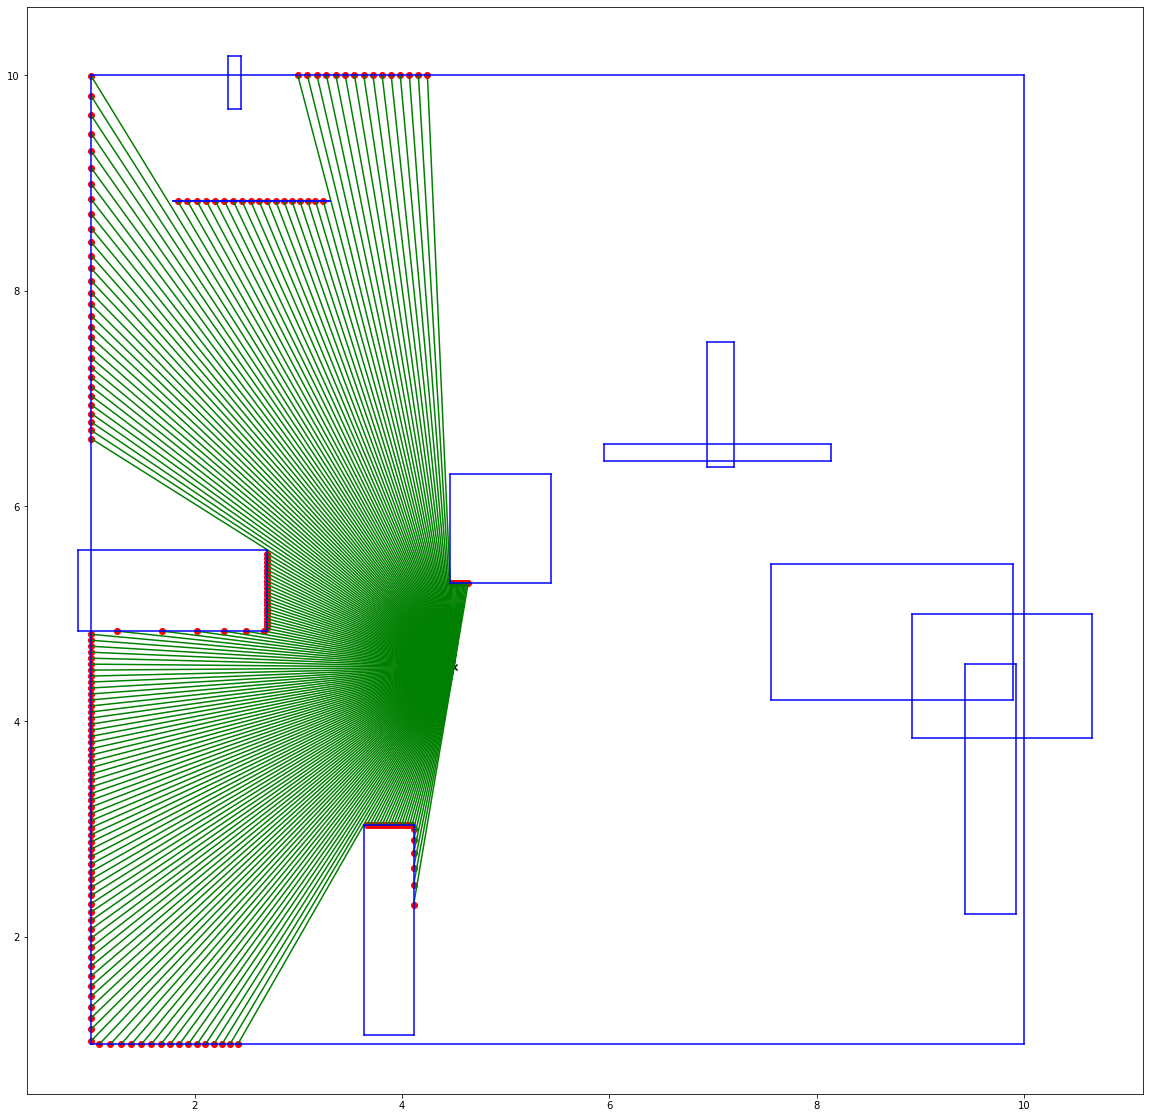

In [31]:
plt.figure(figsize=(20,20))

for ray in rays:
    plt.plot(ray[:,0], ray[:,1], label="ray", color="green")
for line_segment in line_segments:
    plt.plot(line_segment[:,0], line_segment[:,1], label="obstacle", color="blue")
#plt.legend()
plt.scatter(intersection_points[:,0], intersection_points[:,1], color="red")
plt.scatter(pose[0], pose[1], marker="x", color="black")
plt.show()

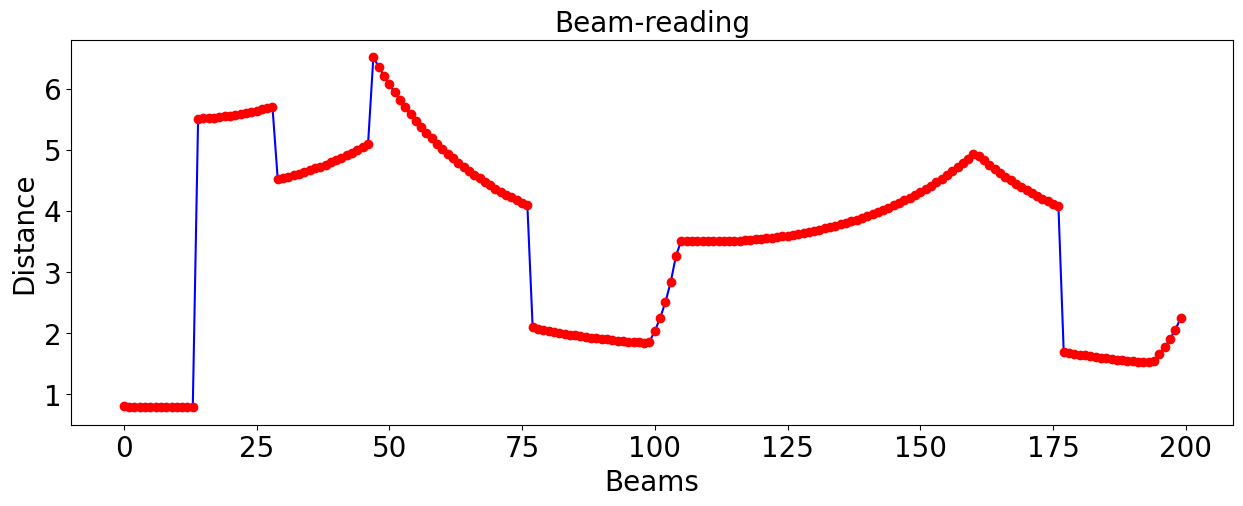

In [18]:
plt.figure(figsize=(15,5))

plt.plot(magnitudes, zorder=-1, color="blue")
plt.scatter(np.arange(200), magnitudes, color="red")
plt.title("Beam-reading", fontsize=20)
plt.xlabel("Beams", fontsize=20)
plt.ylabel("Distance", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()